# Ensemble Learning

## Initial Imports

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [119]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

## Read the CSV and Perform Basic Data Cleaning

In [84]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [94]:
lending_binary_encoded = pd.get_dummies(df, columns=['verification_status','issue_d','next_pymnt_d'])
lending_binary_encoded.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,...,hardship_flag,debt_settlement_flag,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019
0,10500.0,0.1719,375.35,RENT,66000.0,low_risk,n,27.24,0.0,0.0,...,N,N,0,1,0,0,0,1,0,1
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,low_risk,n,20.23,0.0,0.0,...,N,N,0,0,1,0,0,1,0,1
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,low_risk,n,24.26,0.0,0.0,...,N,N,0,0,1,0,0,1,0,1
3,10000.0,0.1640,353.55,RENT,92000.0,low_risk,n,31.44,0.0,1.0,...,N,N,0,0,1,0,0,1,0,1
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,low_risk,n,18.76,0.0,1.0,...,N,N,1,0,0,0,0,1,0,1


In [95]:
le = LabelEncoder()
le.fit(lending_binary_encoded['loan_status'])
lending_binary_encoded["loan_status"] = le.transform(lending_binary_encoded['loan_status'])
le.fit(lending_binary_encoded['home_ownership'])
lending_binary_encoded["home_ownership"] = le.transform(lending_binary_encoded['home_ownership'])
le.fit(lending_binary_encoded['pymnt_plan'])
lending_binary_encoded["pymnt_plan"] = le.transform(lending_binary_encoded['pymnt_plan'])
le.fit(lending_binary_encoded['initial_list_status'])
lending_binary_encoded["initial_list_status"] = le.transform(lending_binary_encoded['initial_list_status'])
le.fit(lending_binary_encoded['application_type'])
lending_binary_encoded["application_type"] = le.transform(lending_binary_encoded['application_type'])
le.fit(lending_binary_encoded['hardship_flag'])
lending_binary_encoded["hardship_flag"] = le.transform(lending_binary_encoded['hardship_flag'])
le.fit(lending_binary_encoded['debt_settlement_flag'])
lending_binary_encoded["debt_settlement_flag"] = le.transform(lending_binary_encoded['debt_settlement_flag'])
lending_binary_encoded.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,...,hardship_flag,debt_settlement_flag,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019
0,10500.0,0.1719,375.35,3,66000.0,1,0,27.24,0.0,0.0,...,0,0,0,1,0,0,0,1,0,1
1,25000.0,0.2000,929.09,1,105000.0,1,0,20.23,0.0,0.0,...,0,0,0,0,1,0,0,1,0,1
2,20000.0,0.2000,529.88,1,56000.0,1,0,24.26,0.0,0.0,...,0,0,0,0,1,0,0,1,0,1
3,10000.0,0.1640,353.55,3,92000.0,1,0,31.44,0.0,1.0,...,0,0,0,0,1,0,0,1,0,1
4,22000.0,0.1474,520.39,1,52000.0,1,0,18.76,0.0,1.0,...,0,0,1,0,0,0,0,1,0,1


## Split the Data into Training and Testing

In [96]:
# Create our features
X = lending_binary_encoded.copy()
X.drop('loan_status', axis=1, inplace=True)
#X.to_csv('binary_encoded_features.csv')
# Create our target
#lending_binary_encoded["loan_status"] = le.transform(lending_binary_encoded['loan_status'])
y = lending_binary_encoded.loan_status.to_frame()

In [97]:
X.describe()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,...,hardship_flag,debt_settlement_flag,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019
count,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.0,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,1.812779,8.821371e+04,0.0,21.778153,0.217766,0.497697,12.587340,...,0.0,0.0,0.478007,0.373992,0.148001,0.371696,0.451066,0.177238,0.383161,0.616839
std,10277.348590,0.048130,288.062432,0.941313,1.155800e+05,0.0,20.199244,0.718367,0.758122,6.022869,...,0.0,0.0,0.499520,0.483865,0.355104,0.483261,0.497603,0.381873,0.486161,0.486161
min,1000.000000,0.060000,30.890000,0.000000,4.000000e+01,0.0,0.000000,0.000000,0.000000,2.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,1.000000,5.000000e+04,0.0,13.890000,0.000000,0.000000,8.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,0.118000,404.560000,1.000000,7.300000e+04,0.0,19.760000,0.000000,0.000000,11.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,24000.000000,0.155700,648.100000,3.000000,1.040000e+05,0.0,26.660000,0.000000,1.000000,16.000000,...,0.0,0.0,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,40000.000000,0.308400,1676.230000,3.000000,8.797500e+06,0.0,999.000000,18.000000,5.000000,72.000000,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
# Check the balance of our target values
y['loan_status'].value_counts()

1    68470
0      347
Name: loan_status, dtype: int64

In [99]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33,random_state=1)
X_train.shape

(46107, 90)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [101]:
# Create the StandardScaler instance
data_scaler = StandardScaler()

In [102]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = data_scaler.fit(X_train)

In [103]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [126]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train_scaled, y_train)
y_pred_brf = brf.predict(X_test_scaled)

In [127]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_brf)

0.7736998802354806

In [128]:
# Display the confusion matrix
cm_brf = confusion_matrix(y_test, y_pred_brf)
cm_brf_df = pd.DataFrame(cm_brf, index=["Actual 0", "Actual 1"], columns=["Predicted 0","Predicted 1"])
display(cm_brf_df)

,Predicted 0,Predicted 1
Actual 0,86,40
Actual 1,3052,19532


In [129]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.03      0.68      0.86      0.05      0.77      0.58       126
          1       1.00      0.86      0.68      0.93      0.77      0.60     22584

avg / total       0.99      0.86      0.68      0.92      0.77      0.60     22710



In [138]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
importances_sorted = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
top_ten_importance = importances_sorted[:10]
top_ten_importance

[(0.0632530631933107, 'total_rec_prncp'),
 (0.06306971539563153, 'total_pymnt'),
 (0.05863453226276277, 'total_rec_int'),
 (0.058324904262512536, 'total_pymnt_inv'),
 (0.05378367519383516, 'last_pymnt_amnt'),
 (0.02692564251541807, 'int_rate'),
 (0.02284266553953271, 'mths_since_recent_inq'),
 (0.021275445731506047, 'issue_d_Jan-2019'),
 (0.018513408533997536, 'installment'),
 (0.01817234268167096, 'tot_hi_cred_lim')]

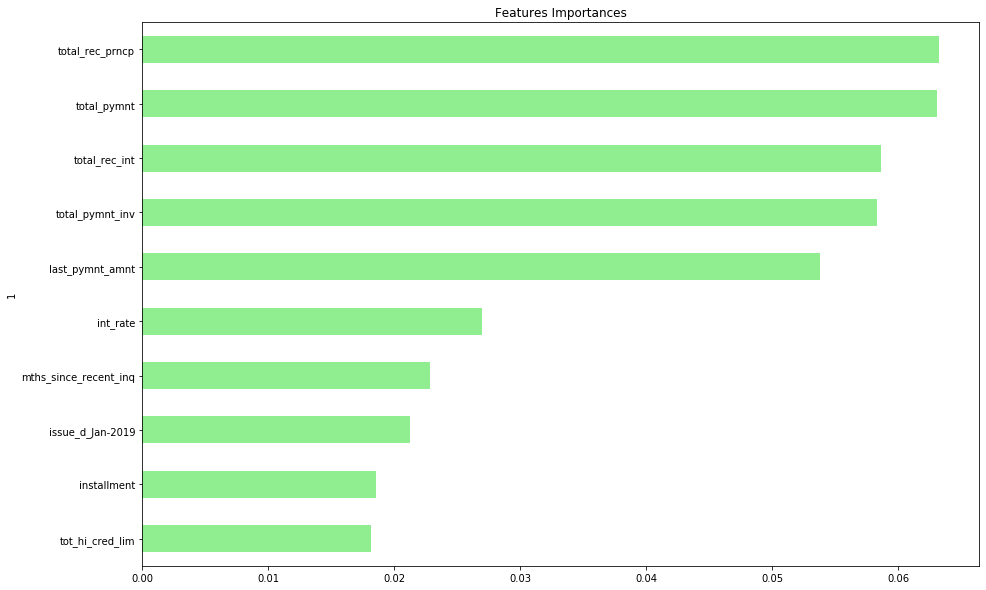

In [141]:
# Plotting Feature Importance Rank
importances_df = pd.DataFrame(top_ten_importance)
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize=(15,10))

### Easy Ensemble Classifier

In [122]:
# Train the Classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
rf_model = rf_model.fit(X_train_scaled, y_train)
y_rf_pred = rf_model.predict(X_test_scaled)

In [123]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_rf_pred)

0.6704135249565643

In [124]:
# Display the confusion matrix
cm_rf = confusion_matrix(y_test, y_rf_pred)
cm_rf_df = pd.DataFrame(cm_rf, index=["Actual 0", "Actual 1"], columns=["Predicted 0","Predicted 1"])
display(cm_rf_df)

,Predicted 0,Predicted 1
Actual 0,43,83
Actual 1,10,22574


In [125]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_rf_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.34      1.00      0.48      0.58      0.32       126
          1       1.00      1.00      0.34      1.00      0.58      0.36     22584

avg / total       1.00      1.00      0.34      1.00      0.58      0.36     22710



### Final Questions

1. Which model had the best balanced accuracy score?

    YOUR ANSWER HERE.

2. Which model had the best recall score?

    YOUR ANSWER HERE.

3. Which model had the best geometric mean score?

    YOUR ANSWER HERE.

4. What are the top three features?

    YOUR ANSWER HERE.

# My Thoughts
1. The Balanced Random Forest model gave us the best score of the 2 models at 77.4%.
2. The Balanced Random Forest model gave me the best recall score of 68%. The Random Forest model gave me the best precision at 81%. 
3. The Balanced Random Forest model gave us the best geometric mean score. Thus, the classification success was higher at 77%.
4. The total recorded principle amount, total payment amount, & total recorded int are the 3 top features.

## In the end, I would select the Balanced Random Forest Model for modeling this set of data.